In [35]:
from sklearn.ensemble import RandomForestClassifier
import numpy as NUM
import SSDataObject as SSDO
import seaborn as SEA
import matplotlib.pyplot as PLOT
import pandas as PD
import arcgisscripting as ARC
import arcpy.management as DM
import arcpy as ARCPY
import SSUtilities as UTILS

In [36]:
#Allow overwriting Feature Classes
ARCPY.env.overwriteOutput = True

##IMPORT DATASET FROM ARCGIS PRO
#Location of the input feature class
inputFC = r'E:\Projects\ML\Seagrass\Seagrass.gdb\FLpointsF_SpatialJoin3'

#Create a SS Data Object
ssdo = SSDO.SSDataObject(inputFC, useChordal = False)

#Names of Preduction Variables
predictVars = ['SALINITY', 'TEMP', 'PHOSPHATE','NITRATE', 
               'SILICATE', 'DISSO2', 'NAMEEMU']

#Names of Classification Variable
classVar = ['PRESENT']

#List of all Variables
allVars = predictVars + classVar
#Obtain Data from Table
ssdo.obtainData(fields = allVars)
#Initialize array to hold all prediction variables
inputVars = NUM.ndarray(shape = (ssdo.numObs, len(allVars)), dtype = object)


In [37]:
##PROCESS CATEGORICAL VARIABLES
#Read all of the prediction variables except String variable
for ind, var in enumerate(allVars):
    inputVars[:, ind] = ssdo.fields[var].data
#Place all of the Non-String Prediction Variables in a Pandas Dataframe
data = PD.DataFrame(inputVars, columns = allVars)
#Display Portion of the Data Frame
data.head()

,SALINITY,TEMP,PHOSPHATE,NITRATE,SILICATE,DISSO2,NAMEEMU,PRESENT
0,35.695,24.7533,0.0705162,0.503541,3.87836,5.03819,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0
1,35.985,24.1374,0.124987,0.836354,1.52161,4.71074,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0
2,35.581,18.0056,1.03244,15.1723,10.7429,3.83999,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",1
3,35.4694,14.5541,0.936634,14.1092,9.92551,3.65459,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",1
4,35.4138,13.4895,0.980522,14.7467,10.7372,3.7217,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0


In [38]:
##Process Categorical Data for Analysis
#Create Numeric Fields for One-Hot Encoding of the Categorical Variable
catVars = PD.get_dummies(data[predictVars[-1]])
#Remove Raw Categories from Dataset
data = data.drop(predictVars[-1], axis = 1)
#Add Processed Categories Back into the Data Frame
data = data.join(catVars)
#Abbreviate Long Categorical Variable Names as c1, c2, c3
newNames = ['c1','c2','c3']
for ind, name in enumerate(newNames):
    data.rename(columns={data.columns[len(predictVars)+ind]:name}, inplace=True)
#Update Predict Variable Names
predictVarsNew = predictVars[:-1] + newNames
#Display Portion of the Data Frame
data.head()

,SALINITY,TEMP,PHOSPHATE,NITRATE,SILICATE,DISSO2,PRESENT,c1,c2,c3
0,35.695,24.7533,0.0705162,0.503541,3.87836,5.03819,0,0,1,0
1,35.985,24.1374,0.124987,0.836354,1.52161,4.71074,0,0,1,0
2,35.581,18.0056,1.03244,15.1723,10.7429,3.83999,1,0,1,0
3,35.4694,14.5541,0.936634,14.1092,9.92551,3.65459,1,0,1,0
4,35.4138,13.4895,0.980522,14.7467,10.7372,3.7217,0,0,1,0


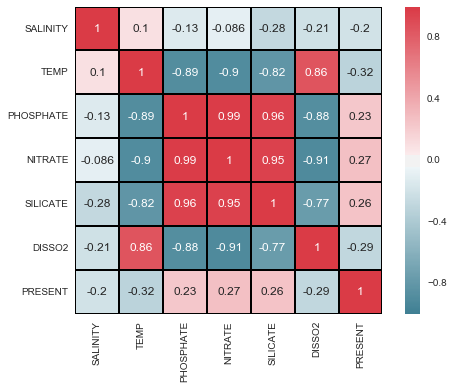

In [39]:
##EVALUATE CORRELATION BETWEEN PREDICTORS- EXCLUDE CATEGORICAL
#Calculate Correlation Coefficient between Prediction Variables
corr = data.drop(data.columns[-3:], axis = 1).astype('float64').corr()

#Plot Correlation Matrix Between Prediction Variables
ax = SEA.heatmap(corr, cmap=SEA.diverging_palette(220, 10, as_cmap=True),
            square=True, annot = True, linecolor = 'k', linewidths = 1)

PLOT.show()

In [40]:
##PERFORM RANDOM FOREST CLASSIFICATION
##PREPARE TRAINING AND TESTING DATA
#Fraction of data to be used in Training
fracNum = 0.1
#Seperate the Data into Training and Test Datasets
train_c1 = data[data['PRESENT'] == 1].sample(frac = fracNum)
train_c0 = data[data['PRESENT'] == 0].sample(frac = fracNum)
#Create Training Dataset
train_set = PD.concat([train_c0, train_c1])
#Create Testing Dataset
test_set = data.drop(train_set.index)
#Encode Seagrass Presence as Classes
indicator, _ = PD.factorize(train_set['PRESENT'])
print('Training Data Size = ' + str(train_set.size))
print('Test Data Size = ' + str(test_set.size))

Training Data Size = 100000
Test Data Size = 900000


In [41]:
##Create Random Forest Classification Object
rfco = RandomForestClassifier(n_estimators = 500)
#Perform Classification Using Training Set
rfco.fit(train_set[predictVarsNew], indicator)
#Predict Seagrass Occurance for the Test Dataset
seagrassPred = rfco.predict(test_set[predictVarsNew])
#Calculate Prediction Accuracy
test_seagrass = test_set.as_matrix(columns =[classVar])
test_seagrass = test_seagrass.flatten()
#Calculate Estimation Error
error = NUM.sum(test_seagrass - seagrassPred)/len(seagrassPred) * 100
#Print Accuracy Metrics
print('Accuracy = ' + str(100 - NUM.abs(error)) + ' % ')
print('Locations with Seagrass = ' + str(len(NUM.where(test_seagrass==1)[0])) )
print('Predicted Locations with Seagrass = ' + str(len(NUM.where(seagrassPred==1)[0])))

Accuracy = 99.7144444444 % 
Locations with Seagrass = 27787
Predicted Locations with Seagrass = 27530


In [42]:
##BRING OUTPUT BACK INTO ARCGIS
#Create a New Feature Class with the Same Spatial Reference
#Get Indeces for the Test Dataset
nameFC = 'Result'
outputFC = r'E:\Projects\ML\Seagrass\Seagrass.gdb\FLpointsResults'
#Get the Indics of Test Points
test_index = NUM.setdiff1d(data.index, train_set.index)
#Define an Indicator for Prediction Accuracy
Indicator = seagrassPred==test_seagrass
#Convert Indicator Variable to a Numeric Variable
Indicator = Indicator * 1.0
outField = SSDO.CandidateField(nameFC, type = "DOUBLE", data = Indicator)
# Get The Number of points
ssdo.numObs = test_index.shape[0]
ssdo.xyCoords = ssdo.xyCoords[test_index]
#Write Out the Result Into a Feature Class
ARC._ss.output_featureclass_from_dataobject(ssdo, outputFC, [outField])

True